In [2]:
import mne
import mne_nirs
import numpy as np
import matplotlib.pyplot as plt
import random

import pywt
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import os
import pandas as pd
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
time_win = 30
sc_factor = 1
sample_rate = 7.81
signal_rate = 7.81
signal_length = time_win * signal_rate
norm_base = 16
print(signal_length)

resting_state_path = "/Users/kostasdemiris/Downloads/snirf/"

'''
Blanco B, Molnar M, Carreiras M, Caballero-Gaudes C. 
Open access dataset of task-free hemodynamic activity in 4-month-old infants during sleep using fNIRS. 
Sci Data. 2022 Mar 25;9(1):102. doi: 10.1038/s41597-022-01210-y. PMID: 35338168; PMCID: PMC8956728.'''


234.29999999999998


'\nBlanco B, Molnar M, Carreiras M, Caballero-Gaudes C. \nOpen access dataset of task-free hemodynamic activity in 4-month-old infants during sleep using fNIRS. \nSci Data. 2022 Mar 25;9(1):102. doi: 10.1038/s41597-022-01210-y. PMID: 35338168; PMCID: PMC8956728.'

In [4]:
# This is the base MNE dataset
fnirs_folder = mne.datasets.fnirs_motor.data_path()
fnirs_cw_amplitude_dir = fnirs_folder / "Participant-1"
raw_intensity = mne.io.read_raw_nirx(fnirs_cw_amplitude_dir, verbose=True)
raw_intensity.load_data()



raw_intensity.annotations.set_durations(time_win)
raw_intensity.annotations.rename(
    {"1.0": "Control", "2.0": "Tapping/Left", "3.0": "Tapping/Right"}
)
unwanted = np.nonzero(raw_intensity.annotations.description == "15.0")
raw_intensity.annotations.delete(unwanted)
# Apparently channel 15 is unrelated to the motor activation experiment,
# it was used to signal something unrelated and so will be ignored

# Removes short channels
picks = mne.pick_types(raw_intensity.info, meg = False, fnirs = True)
dists = mne.preprocessing.nirs.source_detector_distances(
    raw_intensity.info, picks = picks)
raw_intensity.pick(picks[dists > 0.01])



# Converting to optical density based on readings, then to haemo readings
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=6)

# We filter them to remove the frequencies associated with cardiac activity (unrelated)
raw_haemo_unfiltered = raw_haemo.copy()
# raw_haemo.filter(0.05, 0.7, h_trans_bandwidth = 0.2, l_trans_bandwidth = 0.02)



# Creates epochs for each occurence of an event (Left tap, right tap, control)
reject_criteria = dict(hbo=80e-6)
tmin, tmax = -1, time_win-1
events, event_dict = mne.events_from_annotations(raw_haemo)


epochs = mne.Epochs(
    raw_haemo,
    events,
    event_id=event_dict,
    tmin=tmin,
    tmax=tmax,
    reject=reject_criteria,
    reject_by_annotation=True,
    proj=True,
    baseline=(None, 0),
    preload=True,
    detrend=None,
    verbose=True,
)

isolated_event_epochs = epochs["Tapping"]
control_event_set = epochs["Control"]
isol_dhrf_data = isolated_event_epochs.get_data(copy=True)
isol_cont_data = control_event_set.get_data(copy=True)
avg_haemo_func_tapping = isolated_event_epochs.average()
std_dev = np.std(avg_haemo_func_tapping.data, axis=0)

Loading /Users/kostasdemiris/mne_data/MNE-fNIRS-motor-data/Participant-1
Reading 0 ... 23238  =      0.000 ...  2974.464 secs...
Used Annotations descriptions: ['Control', 'Tapping/Left', 'Tapping/Right']
Not setting metadata
90 matching events found
Setting baseline interval to [-1.024, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 90 events and 236 original time points ...
0 bad epochs dropped


In [5]:
sfreq = 7.81
amp = .4

raw = mne_nirs.simulation.simulate_nirs_raw(
    sfreq=sfreq, sig_dur=60 * 5, amplitude=amp, isi_min=30., isi_max=60.)

print(np.shape(raw.get_data()))
experimental_overlay = isol_cont_data.copy()
associated_hrfs = []
print(np.shape(experimental_overlay))
index = 0
while index < len(experimental_overlay):
    hrf_tape = mne_nirs.simulation.simulate_nirs_raw(
        sfreq=sfreq, sig_dur=60 * 5, amplitude=amp, isi_min=30., isi_max=60.)
    hrf_data = hrf_tape.get_data()[0]
    generated_hrf, event_id = mne.events_from_annotations(hrf_tape)
    for starting_point in generated_hrf:
        if index < len(experimental_overlay) and starting_point[0] + signal_length < len(hrf_data):
            experimental_overlay[index][0] += hrf_data[starting_point[0]: starting_point[0] + len(experimental_overlay[index][0])]
            associated_hrfs.append(hrf_data[starting_point[0]: starting_point[0] + len(experimental_overlay[index][0])])
            index += 1
print(len(experimental_overlay), "done")


(1, 2343)
(30, 40, 236)
Used Annotations descriptions: ['A']
Used Annotations descriptions: ['A']
Used Annotations descriptions: ['A']
Used Annotations descriptions: ['A']
Used Annotations descriptions: ['A']
Used Annotations descriptions: ['A']
Used Annotations descriptions: ['A']
30 done


In [7]:
class display:
    def __init__(self, time_sig):
        self.time_signal = time_sig
    
    def display_gray_arr(self, img_arr):
        plt.imshow(img_arr, cmap='gray')
        plt.title("Wavelet As Image")
        plt.axis('off')
        plt.show()
    
    def plot_pChannel(self, points, time_series):
        plt.figure(figsize=(10, 4))
        plt.plot(time_series, points)
        plt.title("channel")
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.show()
        plt.clf()
        
    def plot_multiChannel(self, channel_arr, time_series):
        fig, ax = plt.subplots()
        for i, array in enumerate(channel_arr):
            ax.plot(time_series, channel_arr[i], label="Channel {i+1}")
        ax.set_xlabel('Time: in seconds')
        ax.set_ylabel('Amplitude ')
        ax.set_title('Multiple Channels plotted on one image')
    
    def plot_scatter_data(self, data_points, central=0.5):
        # Useful for power spectra, not currently used but could be
        plt.scatter([i for i in range(len(data_points))], data_points, color='white', alpha=0.5)

        for i in range(len(data_points)):
            plt.plot([i, i], [data_points[i], central], color='red', alpha=0.5)

        plt.axhline(y=central, color='green', linestyle='--')

        plt.title('Scatter plot')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.grid(True)
        plt.show()
        
    def plot_comparision_data(self, original_data, reconstructed_data, time_signal):
        plt.figure(figsize=(10, 6))
        plt.plot(time_signal, original_data, label='Original')
        plt.plot(time_signal, reconstructed_data, label='Reconstructed')
        plt.title('Comparision')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.show()
        plt.clf()
        
    def plot_wavedec_spect(self, coeffs):
        coefficients_array = []
        max_length = max(len(i) for i in coeffs)
        
        for level, row in enumerate(coeffs):
            stretched_row = np.repeat(row, np.ceil(max_length / len(row)).astype(int))
            coefficients_array.append(stretched_row[:max_length]) # Again, this is just for display, not actually used
            
            
        coeffs_matrix = np.vstack(coefficients_array)
        norm_coeff_matrix = np.repeat(normalise(coeffs_matrix), 3, axis=0)
        
        print(f"shape is {np.shape(norm_coeff_matrix)}")
        plt.clf()
        plt.figure(figsize=(10, 5))
        plt.imshow(norm_coeff_matrix, cmap='brg')
        plt.colorbar(label='Magnitude')
        plt.ylabel('Depth')
        plt.xlabel('Time')
        plt.title('WAVEDEC DISPLAY SPECTOGRAM')
        plt.show()
        
    def plot_wavedec_layer(self, coeffs, start_time=-1, stop_time=time_win-1):
        for depth, row in enumerate(coeffs):
            plt.figure(figsize=(10, 4))
            time_row = np.linspace(start_time, stop_time, num=len(row))
            plt.plot(time_row, row)
            plt.title(f"wavelet level {depth + 1}")
            plt.xlabel("Time")
            plt.ylabel("Amplitude")
            plt.show()
            
    def plot_comp_wavedec_layer(self, coeffs, recoefs, start_time=-1, stop_time=time_win-1):
        for depth, row in enumerate(coeffs):
            plt.figure(figsize=(10, 4))
            time_row = np.linspace(start_time, stop_time, num=len(row))
            plt.plot(time_row, row, label='Original')
            plt.plot(time_row, recoefs[depth], label='Reconstructed')
            plt.title(f"wavelet level {depth + 1}")
            plt.xlabel("Time")
            plt.ylabel("Amplitude")
            plt.legend()
            plt.show()

class Normalisations:
    def __init__(self):
        pass
    
    def z_normalisation(self, data, d_mean, d_std):
        return (data - d_mean) / d_std
    
    def inv_z_normalisation(self, data, d_mean, d_std):
        return (data * d_std) + d_mean
    
class Conversions:
    def __init__(self):
        pass
    
    def cwt(self, complex_signal, wavelet='cmor', sample_rate=sample_rate):
        # Using this cmor wavelet for the cwt, it's the complex morlet wavelet 
        scales = np.arange(1, 129)  
        coefficients, frequencies = pywt.cwt(complex_signal, scales, wavelet, sampling_period=1/sample_rate)
        return coefficients, frequencies

    
    def dwt(self, data, wavelet='db4'):
        # db4 is chosen as the default basis function because it looks like the canonical hrf (kinda).
        coefficients, frequencies = pywt.dwt(data, wavelet)
        return coefficients, frequencies
    
    def wavedec(self, data, wavelet='sym4'):
        max_depth = pywt.dwt_max_level(len(data), wavelet)
        coeffiecients = pywt.wavedec(data, wavelet, level=max_depth)
        return coeffiecients
    
    def waverec(self, coefficients, wavelet='sym4'):
        recovered = pywt.waverec(coefficients, wavelet)
        return recovered
    
    def inv_dwt(self, coeffs, freqs, wavelet='sym4'):
        return pywt.idwt(coeffs, freqs, wavelet)

class Evaluations:
    def __init__(self):
        pass
    
    def root_signal_power(self, signal):
        square_sum = np.sum(np.power(signal, 2)) 
        root_mean = (square_sum / len(signal)) ** 0.5
        return root_mean
        
    def signal_to_noise_ratio(self, signal, noise):
        # Not exactly signal to noise. I'm using root of signal power because it was better for my purposes i guess
        signal_power = self.root_signal_power(signal)
        noise_power = self.root_signal_power(noise)
        return signal_power / signal_noise
    
    def contrast_to_noise(self, signal, noise):
        signal_power = self.root_signal_power(signal)
        noise_power = self.root_signal_power(noise)
        std_noise = np.std(noise)
        return np.abs(signal_power - noise_power) / std_noise
    
    def root_mean_square_error(self, recon_signal, target_signal):
        mean_error = np.mean((target_signal - recon_signal) ** 2)
        return (mean_error ** 0.5)
    
    def peak_signal_to_noise_ratio(self, signal, desired_signal, max_i = 1):
        # Maximum possible intensity (max_i) is assumed to be 1 due to normalisation
        return (20 * np.log(10, max_i)) - (10 * np.log(10, self.root_mean_square_error(signal, desired_signal))) 
    
class Generations:
    def __init__(self):
        pass
    
    def gen_frequency(self, frequency, amplitude, sample_rate, point_number, starting_offset=0):
        f_timeseries, step_interval = [], 1 / (sample_rate * frequency)
        for time in range(point_number):
            f_timeseries.append(amplitude * math.sin(time * step_interval))
        return np.array(f_timeseries)
    
    def gen_vari_frequency(self, frequency, f_variability, amplitude, a_variability, sample_rate, point_number, starting_offset=0):
        f_timeseries, step_interval = [], 1 / (sample_rate * frequency)
        target_frequency = np.random.normal(frequency, f_variability)
        target_amplitude = np.random.normal(amplitude, a_variability)
        for time in range(point_number):
            if time % 100 == 0:
                target_frequency = np.random.normal(frequency, f_variability)
                target_amplitude = np.random.normal(amplitude, a_variability)
                target_frequency = max(target_frequency, 1e-6)
                target_amplitude = max(target_amplitude, 1e-10)
            frequency += 0.1 * np.log(target_frequency) - np.log(frequency)
            amplitude += 0.01 * amplitude * (np.log(target_amplitude) - np.log(amplitude))
            step_interval =1 / (sample_rate * frequency)
            value = (amplitude * math.sin(time * step_interval * frequency))
            if np.isnan(value):
                print(f"amp {amplitude}, targ amp {target_amplitude}, freq {frequency}, time {time}, step_int {step_interval}")

            f_timeseries.append(value)
        return np.array(f_timeseries)
    
    def gen_motion_artifact(self, signal_length, sample_rate = sample_rate, peak_amp_range=(0.25e-6, 1e-6), time_to_peak = 7.0, random_scale = (0.5, 1.5)):
        peak_amp_range = np.random.uniform(peak_amp_range[0], peak_amp_range[1])
        random_scale = np.random.uniform(random_scale[0], random_scale[1])
        time_to_peak = time_to_peak + (random.uniform(-50, 50) * (1/sample_rate))
        
        motion_artifact = np.array([(peak_amp_range * np.exp(- np.absolute((t / sample_rate) - time_to_peak) / random_scale)) for t in range(signal_length)])
        return motion_artifact
    
    # -------------- Individual Component Generation Section -----------
    
    def gen_white_noise(self, point_num):
        return np.random.random_sample(size=(point_num,)) - 0.5
    
    def gen_nirs_data(self, sample_rate, signal_length, amplitude, min_nirs_interval=15.0, max_nirs_interval=45.0):
        return mne_nirs.simulation.simulate_nirs_raw(sfreq=sample_rate, sig_dur=signal_length, amplitude=amplitude, isi_min=min_nirs_interval, isi_max=max_nirs_interval)
    
    def gen_heart_signal(self, sample_rate, point_num, frequency=0.8, variability=0.03, amplitude=1e-7):
        #heart_sig = self.gen_frequency(frequency, amplitude, sample_rate, point_num, random.randint(0, 100))
        heart_sig = self.gen_vari_frequency(frequency, variability, amplitude, amplitude/5, sample_rate, point_num, starting_offset=random.randint(0, 100))
        return heart_sig
    
    def gen_mayer_signal(self, sample_rate, point_num, frequency=0.1, amplitude=5e-8):
        mayer_sig = self.gen_frequency(frequency, amplitude, sample_rate, point_num, random.randint(0, 100))
        return mayer_sig
    
    def gen_respi_signal(self, sample_rate, point_num, frequency=0.333, amplitude=1e-7):
#         respi_sig = self.gen_frequency(frequency, amplitude, sample_rate, point_num, random.randint(0, 100))
        respi_sig = self.gen_vari_frequency(frequency, frequency/25, amplitude, amplitude/5, sample_rate, point_num, starting_offset=random.randint(0, 100))
        return respi_sig
    
    def gen_resting_state_data(self, sample_rate, point_num):
        heart_signal = self.gen_heart_signal(sample_rate, point_num)
        mayer_signal = self.gen_mayer_signal(sample_rate, point_num)
        respi_signal = self.gen_respi_signal(sample_rate, point_num)
#         if np.any(np.isnan(heart_signal)) or np.any(np.isnan(mayer_signal)) or np.any(np.isnan(respi_signal)):
#             print(f"heart {heart_signal}, mayer {mayer_signal}, respi {respi_signal}")
        return heart_signal + mayer_signal + respi_signal
    
    def generate_basic_test_data(self, data_length, sample_length=np.ceil(signal_length).astype(int)):
        index = 0
        test_size, hrf_number = data_length, data_length
        hrf_set = np.zeros((test_size, sample_length))

        while index < hrf_number:
            print(f"Index is currently {index}")
            hrf_tape = mne_nirs.simulation.simulate_nirs_raw(
                    sfreq=sfreq, sig_dur=60 * 50, amplitude=amp, isi_min=30., isi_max=60., stim_dur=random.uniform(3., 6.))
            hrf_data = hrf_tape.get_data()[0]
            generated_hrf, event_id = mne.events_from_annotations(hrf_tape)

            for start in generated_hrf:
                if index < hrf_number and start[0] + sample_length < len(hrf_data):
                    hrf_set[index] = (hrf_data[start[0]: start[0] + sample_length])
                    index += 1
        np.random.shuffle(hrf_set) # Random distribution of hrf and "quiet" signals

        overlay_data = np.array([
            np.roll(generator.gen_resting_state_data(sample_rate, sample_length)
            + (generator.gen_white_noise(sample_length) * 1e-7),
                   random.randint(0, 100))
            for data_point in range(len(hrf_set))
        ])


        extract_data = np.zeros((test_size, sample_length))
        for i in range(len(extract_data)):
            shift_index = random.randint(0, (sample_length)//5)
            extract_data[i] = np.concatenate((np.full(shift_index, 1e-15), (hrf_set[i] * np.random.uniform(low=0.6, high=1.4))[:sample_length-shift_index]))
#             extract_data[i] =  hrf_set[i] * np.random.uniform(low=0.6, high=1.4)
        
        return extract_data, overlay_data
    
    # ---------------------- End of Individual Component Section -------------------
    
    
# Data Generation models
class Auto_Regressive_Model():
    # Uses the direct relation between the previous k (order) values to forecast the subsequent value in a time series
    # Suitable for when the ACF plot has a slowly decreasing tail, with the highest significant PACF value being order
    def __init__(self, order):
        self.k = order
        self.model = LinearRegression()
        self.std = None
    
    def generate_training_data(self, data):
        # returns the inp. data, an array of k long sequences, and outp. data, array of the respective k+i+1'th values
        n = len(data)
                
        x_data = np.reshape(data[:n - self.k], (-1, 1))
        for i in range(1, self.k):
            x_data = np.hstack((x_data, np.reshape(data[i: n - self.k + i], (-1, 1))))

        y_data = data[self.k:]
        return np.array(x_data), np.array(y_data)
    
    def fit(self, data):
        self.std = np.std(data)
        training_x, training_y = self.generate_training_data(data)
        self.model.fit(training_x, training_y)
    
    def predict(self, data, steps, mc_depth, iterative_averaging=False):
        # Steps refers the number of points that it will return in the future, and mc_depth is the number of monte 
        # carlo simulations that we'll average to return the data
        assert(mc_depth > 0 and steps > 0)
        
        inputted, output = np.array(data), []
        tape = inputted[-self.k:]
        if iterative_averaging:
            # This approach predicts the next value r (mc_depth) times, then averages that and uses it as the subq. input
            # reduces compounding error from consecutive inaccurate predictions, but is more comp. expensive and still 
            # can have bias if it accumalates over many predictions.
            for step in range(steps):
                temp_next = 0
                
                for sim in range(mc_depth):
                    temp_next += (self.model.predict(np.reshape(tape, (1, -1))).item() + np.random.normal(scale = self.std))
                    # we add an error term to prediction to conser the unpredictability and also for some non-determinism
                
                tape = np.roll(tape, -1)
                next_point = temp_next / mc_depth
                tape[-1] = next_point
                output.append(next_point)
            
            output = np.array(output)
            
        else:
            # averaging r (mc_depth) different simulations of k (order) points
            
            output_acc = np.array([])
            # Accumulates all of the simulations
            
            for sim in range(mc_depth):
                tape = inputted[-self.k:]
                temp_output = []
                
                for step in range(steps):
                    temp_next = self.model.predict(np.reshape(tape, (1, -1))).item() + np.random.normal(scale = self.std)
                    temp_output.append(temp_next)
                    
                    tape = np.roll(tape, -1)
                    tape[-1] = (temp_next)
                    
                if sim == 0:
                    output_acc = np.array(temp_output)
                else:
                    output_acc += np.array(temp_output)
            
            output = output_acc / mc_depth 
        
        return output
    
class Differencer():
    # Converts non stationairy (properties change depend on time period of observation) data to stationairy data
    # by taking the change in the data (each point becomes the difference between itself and the previous value)
    # k (order) times.
    def __init__(self):
        pass
    
    def augmented_Dickey_Fuller_test(self, data, sig_lev=0.05):
        # the ADF test, useful for finding the order of differences that are necessary to produce stationairy data.
        # returns whether the data at this level of difference is stationairy. Statistics so is inaccurate at small sample sizes
        result = adfuller(data)
        # result[1] is the p value of the test, and if it is less than 0.05, the data is significant and we reject h0
        # so no unit root ergo it's stationairy
        return (result[1] < sig_lev)

    
    def stationairy_conv(self, data, significance_level=0.05):
        output = np.array(data)
        while not self.augmented_Dickey_Fuller_test(output, sig_lev = significance_level):
            output = self.difference(output)
            
        return output
    
    def difference(self, data):
        base = np.array(data)
        return np.concatenate((np.zeros(1), base[1:] - base[:-1]))
    
    def inv_difference(self, original, differenced_data, order=1):
        differenced_data[0] = original
        for i in range(order):
            differenced_data = np.cumsum(differenced_data)
        return differenced_data
    
class Statistics():
    # This is just some statistic tests that I'm working with.
    def __init__(self):
        pass
    
    def partial_autocorrelation_test(self, data, maximum_degree=None):
        # the PACF test, useful for finding the lag to use for an Autoregressive model (AR)
        return pacf(data, nlags=maximum_degree)

    def autocorrelation_test(self, data, maximum_degree=None):
        # the ACF test, useful for finding the lag to using for a Moving Average model (MA)
        if maximum_degree is None:
            maximum_degree = math.floor(math.sqrt(len(data)))
            # the maximum lag coefficient that will be tested.
        dataframe = pd.DataFrame(data)
        shifted_dataframe = pd.concat([dataframe.shift(-k) for k in range(0, maximum_degree + 1)], axis = 1)
        # The correlation between t and itself is always 1 by the way
        correlation = shifted_dataframe.corr()
        correlation.columns = [f't-{k}' for k in range(0, maximum_degree + 1)]

        data = correlation.iloc[0, 0:]
    
        return data.to_numpy()


        
time_signal = np.arange(len(avg_haemo_func_tapping.data[0])) * (1/signal_rate)      
displays = display(time_signal)
norms = Normalisations()
convs = Conversions()
evals = Evaluations()
diff = Differencer()
ar_model = Auto_Regressive_Model(6)
generator = Generations()
stats = Statistics()


Reading 0 ... 8045  =      0.000 ...   901.040 secs...


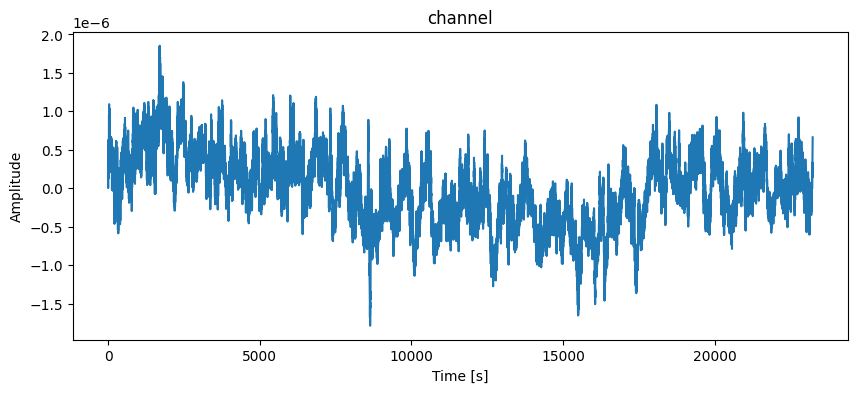

<Figure size 640x480 with 0 Axes>

In [8]:
def load_snirf_data(folder_path, ID=0):
    raw_data_array = []
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.snirf'):

                snirf_file_path = os.path.join(folder_path, file_name)
                raw_object = mne.io.read_raw_snirf(snirf_file_path, verbose=False)
                
                annotation = mne.Annotations(onset=[0], duration=[raw_object.times[-1]  - raw_object.times[0]], description=[f"Subject ID: {ID}"])
                # Onset starts at 0, the start, and duration is until the last sample (so covers the whole thing)
                ID += 1

                raw_object.set_annotations(annotation)
                raw_data_array.append(raw_object)
    
    return raw_data_array


def get_time_series_from_snirf_data(snirf_file_path):
    raw_object = mne.io.read_raw_snirf(snirf_file_path, verbose=False)
    raw_object.load_data()
    
    # Removes short channels. They're useful for my single channel denoising program since they can't pick up hrf.
    raw_picks = mne.pick_types(raw_object.info, meg = False, fnirs = True)
    channel_distances = mne.preprocessing.nirs.source_detector_distances(raw_object.info, picks = raw_picks)
    raw_object.pick(raw_picks[channel_distances > 0.01])

    optical_density = mne.preprocessing.nirs.optical_density(raw_intensity)
    haemo_recording = mne.preprocessing.nirs.beer_lambert_law(optical_density, ppf=6)
    haemo_data = haemo_recording.get_data()
    
    return haemo_data
    

time_state_data = np.array(get_time_series_from_snirf_data("/Users/kostasdemiris/Downloads/snirf/RS4_SL_4219.snirf"))

displays.plot_pChannel(time_state_data[0], np.arange(0, len(time_state_data[0]-1)))


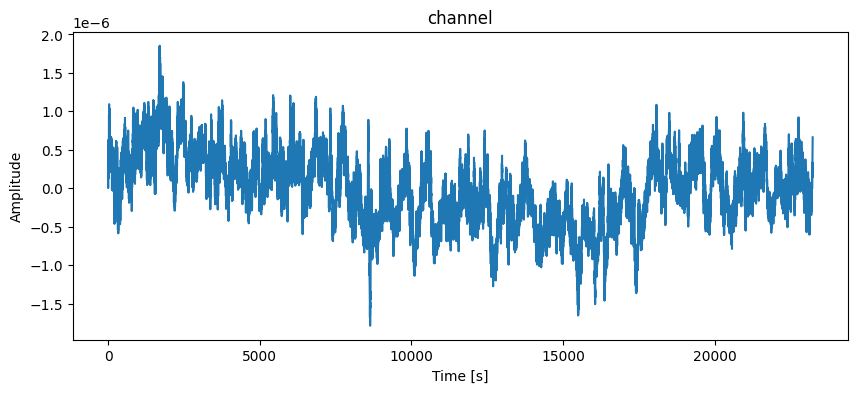

<Figure size 640x480 with 0 Axes>

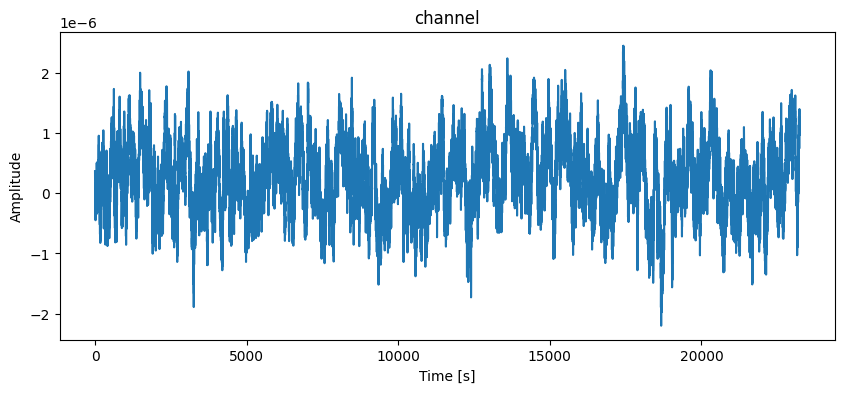

<Figure size 640x480 with 0 Axes>

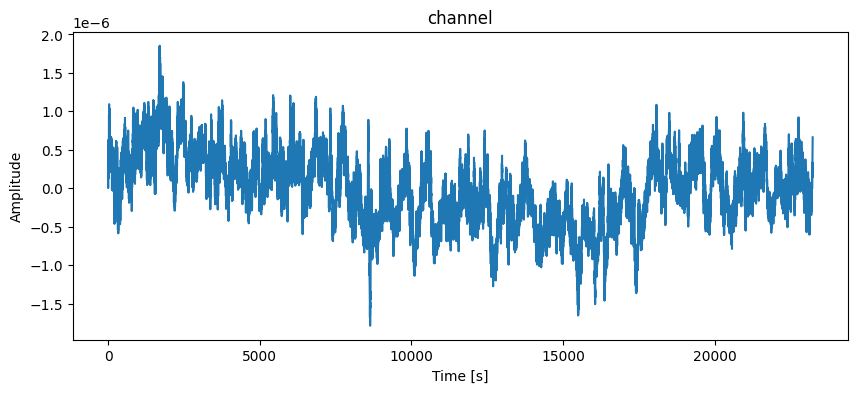

6.020869142877711e-07 2.5999686489486014e-07
4.643602872182497e-07 1.1044720772572659e-08


<Figure size 640x480 with 0 Axes>

In [10]:
displays.plot_pChannel(time_state_data[0], np.arange(0, len(time_state_data[0] - 1)))

base_state_value, differenced_data = time_state_data[0][0], diff.difference(time_state_data[0])
# displays.plot_pChannel(differenced_data, np.arange(0, len(time_state_data[0] - 1)))

# pACF_result = stats.partial_autocorrelation_test(time_state_data[0])
# ACF_result = stats.autocorrelation_test(time_state_data[0])

# displays.plot_pChannel(pACF_result, range(len(pACF_result)))
# displays.plot_pChannel(ACF_result, range(len(ACF_result)))
# print(diff.augmented_Dickey_Fuller_test(time_state_data[0]), diff.augmented_Dickey_Fuller_test(differenced_data))
ar_rsd = Auto_Regressive_Model(8)
# Autoregressive model for resting state data (rsd)

base_state_val, differenced_state_data = time_state_data[0][0], diff.difference(time_state_data[0])

ar_rsd.fit(time_state_data[0][:500])
data_to_use = ar_rsd.predict(time_state_data[0][:10], len(time_state_data[0]), 3, iterative_averaging=True)
displays.plot_pChannel(data_to_use, np.arange(len(time_state_data[0])))
displays.plot_pChannel(time_state_data[0], np.arange(0, len(time_state_data[0] - 1)))

# ar_rsd.fit(differenced_data)
# undiffed_data = diff.inv_difference(base_state_val, ar_rsd.predict(differenced_data, len(differenced_data), 200, iterative_averaging=True))
# displays.plot_pChannel(diff.inv_difference(base_state_val, differenced_data), range(len(differenced_data)))
# displays.plot_pChannel(undiffed_data, range(len(undiffed_data)))
print(np.std(data_to_use), np.mean(data_to_use))
print(np.std(time_state_data[0]), np.mean(time_state_data))
# displays.plot_pChannel(diff.inv_difference(base_state_value, differenced_data), np.arange(0, len(time_state_data[0] - 1)))


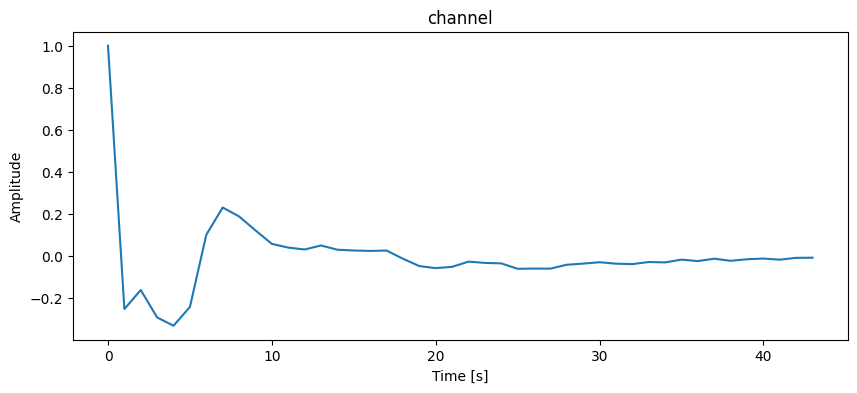

<Figure size 640x480 with 0 Axes>

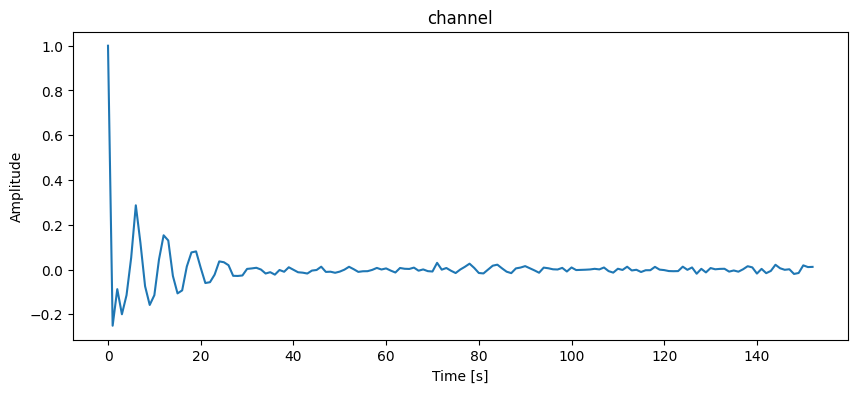

[ 1.         -0.25086509 -0.16057562 -0.29078548 -0.3301235  -0.24088953
  0.10211367  0.23144555  0.18896085  0.12273912  0.05872005  0.04097179
  0.03203005  0.0510671   0.03096091  0.02716815  0.02526775  0.02694612
 -0.01179045 -0.046842   -0.05653756 -0.05043142 -0.02572283 -0.0316415
 -0.03406616 -0.05956888 -0.05864555 -0.05898719 -0.04045294 -0.03503351
 -0.02858012 -0.03530916 -0.03745929 -0.0276016  -0.0292344  -0.01619027
 -0.02309093 -0.01159418 -0.02178446 -0.01440033 -0.01109008 -0.01633869
 -0.00759798 -0.00700029]


<Figure size 640x480 with 0 Axes>

In [11]:
pACF_result = stats.partial_autocorrelation_test(differenced_data)
ACF_result = stats.autocorrelation_test(differenced_data)

displays.plot_pChannel(pACF_result, range(len(pACF_result)))
displays.plot_pChannel(ACF_result, range(len(ACF_result)))
print(pACF_result)

In [ ]:
print(np.std(data_to_use), np.mean(data_to_use))
print(np.std(time_state_data[0]), np.mean(time_state_data))

In [ ]:
ra = random.randint(0, len(data_to_use) - 1)

In [ ]:
ra = random.randint(0, len(data_to_use) - 1)
displays.plot_pChannel(data_to_use[ra: ra+ 200], range(200))
displays.plot_pChannel(time_state_data[0][ra: ra+ 200], range(200))

In [12]:
# Data Generation models
class Auto_Regressive_Model():
    # Uses the direct relation between the previous k (order) values to forecast the subsequent value in a time series
    # Suitable for when the ACF plot has a slowly decreasing tail, with the highest significant PACF value being order
    def __init__(self, order):
        self.k = order
        self.model = LinearRegression()
        self.std = None
    
    def generate_training_data(self, data):
        # returns the inp. data, an array of k long sequences, and outp. data, array of the respective k+i+1'th values
        n = len(data)
                
        x_data = np.reshape(data[:n - self.k], (-1, 1))
        for i in range(1, self.k):
            x_data = np.hstack((x_data, np.reshape(data[i: n - self.k + i], (-1, 1))))

        y_data = data[self.k:]
        return np.array(x_data), np.array(y_data)
    
    def fit(self, data):
        self.std = np.std(data)
        training_x, training_y = self.generate_training_data(data)
        self.model.fit(training_x, training_y)
    
    def predict(self, data, steps, mc_depth, iterative_averaging=False):
        # Steps refers the number of points that it will return in the future, and mc_depth is the number of monte 
        # carlo simulations that we'll average to return the data
        assert(mc_depth > 0 and steps > 0)
        
        inputted, output = np.array(data), []
        tape = inputted[-self.k:]
        if iterative_averaging:
            # This approach predicts the next value r (mc_depth) times, then averages that and uses it as the subq. input
            # reduces compounding error from consecutive inaccurate predictions, but is more comp. expensive and still 
            # can have bias if it accumalates over many predictions.
            for step in range(steps):
                temp_next = 0
                
                for sim in range(mc_depth):
                    temp_next += (self.model.predict(np.reshape(tape, (1, -1))).item() + np.random.normal(scale = self.std))
                    # we add an error term to prediction to conser the unpredictability and also for some non-determinism
                
                tape = np.roll(tape, -1)
                next_point = temp_next / mc_depth
                tape[-1] = next_point
                output.append(next_point)
            
            output = np.array(output)
            
        else:
            # averaging r (mc_depth) different simulations of k (order) points
            
            output_acc = np.array([])
            # Accumulates all of the simulations
            
            for sim in range(mc_depth):
                tape = inputted[-self.k:]
                temp_output = []
                
                for step in range(steps):
                    temp_next = self.model.predict(np.reshape(tape, (1, -1))).item() + np.random.normal(scale = self.std)
                    temp_output.append(temp_next)
                    
                    tape = np.roll(tape, -1)
                    tape[-1] = (temp_next)
                    
                if sim == 0:
                    output_acc = np.array(temp_output)
                else:
                    output_acc += np.array(temp_output)
            
            output = output_acc / mc_depth 
        
        return output
    
class Differencer():
    # Converts non stationairy (properties change depend on time period of observation) data to stationairy data
    # by taking the change in the data (each point becomes the difference between itself and the previous value)
    # k (order) times.
    def __init__(self):
        pass
    
    def augmented_Dickey_Fuller_test(self, data, sig_lev=0.05):
        # the ADF test, useful for finding the order of differences that are necessary to produce stationairy data.
        # returns whether the data at this level of difference is stationairy. Statistics so is inaccurate at small sample sizes
        result = adfuller(data)
        # result[1] is the p value of the test, and if it is less than 0.05, the data is significant and we reject h0
        # so no unit root ergo it's stationairy
        return (result[1] < sig_lev)

    
    def stationairy_conv(self, data, significance_level=0.05):
        output = np.array(data)
        while not self.augmented_Dickey_Fuller_test(output, sig_lev = significance_level):
            output = self.difference(output)
            
        return output
    
    def difference(self, data):
        base = np.array(data)
        return np.concatenate((np.zeros(1), base[1:] - base[:-1]))
    
    def inv_difference(self, original, differenced_data, order=1):
        differenced_data[0] = original
        for i in range(order):
            differenced_data = np.cumsum(differenced_data)
        return differenced_data

In [13]:
class CWH_ToTensor:
    # Channels, then width then height. Basic toTensor() from transforms does not support data of my shape.
    def __call__(self, x):
        return torch.tensor(x, dtype=torch.float32)

class Log_Transform:
    def __call__(self, data, base = norm_base):
        return np.emath.logn(base, data) .astype('float32')
    # This doesn't need an adjustment for zero because np.log1p just returns zero for that.
    # An adjustment would also throw very big errors in because a small adjustment would mean very negative outputs.
        

pad_log_transform = transforms.Compose([
#     Log_Transform(),
    CWH_ToTensor()
])

simple_to_tensor = transforms.Compose([
    transforms.Lambda(lambda x: x.astype('float32')),
    transforms.ToTensor()
]
)

In [14]:
# class Linear_regressor(torch.nn.Module):
#     # https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817 <-- tutorial for this
#     def __init__(self):
#         super().__init__()  
#         self.linear_layer = None
    
#     def forward(self, x):
#         pred = self.linear_layer(x)
#         return pred
    
#     def fit(self, x_train, y_train, epoch_num=50):
#         print(np.shape(x_train), np.shape(y_train))
#         # Only works with one dimensional data because I don't need it to do anything beyond that.
#         self.linear_layer = torch.nn.Linear(len(x_train[0]), len(y_train[0]))
#         loss_func = torch.nn.MSELoss() 
#         optimiser = torch.optim.SGD(self.parameters(), lr=1e-4)
        
#         for epoch in range(epoch_num):
#             inputs = Variable(torch.from_numpy(x_train))
#             labels = Variable(torch.from_numpy(y_train))
            
#             optimiser.zero_grad()
#             outputs = self(inputs)
            
#             pred_loss = loss_func(outputs, labels)
#             pred_loss.backward()
#             optimiser.step()
            
#         print(f"Final loss of {pred_loss.item()%.4}")
        
#     def predict(self, tape):
#         return self(torch.from_numpy(tape))
    
# class AutoRegression:
#     def __init__(self, order):
#         self.order = order 
#         # The order of an AutoRegression model is the number of previous variables used to calculate the next one
#         self.model = Linear_regressor()
#         self.std = None
        
#     def generate_predictor_data(self, data_set):
#         n = len(data_set)
        
#         data = data_set[:n - self.order]
#         data = np.reshape(data, (-1, 1))
        
#         # This takes the values from index 0 up to n-order and reshapes them into a column vector 
#         # We then stack the values from index 1 to (n-order) + 1. 
        
#         # If we hadn't done 0 independently, we'd have nothing to stack onto
#         for i in range(1, self.order):
#             temp_col = data_set[i:(n+i) - self.order]
#             temp_col = np.reshape(temp_col, (-1, 1))
#             np.hstack((data, temp_col))
            
#         return data
    
#     def generate_responce_data(self, data_set):
#         return data_set[self.order:]
    
#     def fit(self, data_set):
#         self.std = np.std(data_set)
#         t_x_data = self.generate_predictor_data(data_set)  # X data for training
#         t_y_data = self.generate_responce_data(data_set)  # Y data for training
#         self.model.fit(t_x_data, t_y_data)
        
#     def predict(self, data_set, step_count, simulation_num):
#         data_set = np.array(data_set)
#         output = np.array([])
        
#         for sim in range(simulation_num):
#             # We do a monte carlo simulation approach, performing a bunch of simulations, then averaging them
#             temp_ans = []
#             tape = data_set[-self.order:]
#             # Take the last order num values as a rolling tape measure, then keep rolling back to the start
#             # along the tape, putting in our predicted values in as we go
            
#             for prediction in range(step_count):
#                 predicted = self.model.predict(np.reshape(tape, (-1, 1)))
#                 predicted += np.random.normal(loc=0, scale=self.std)
#                 # We predict the next value, then add some gaussian noise to it depending on the standard
#                 # deviation of the original dataset we were using...
                
#                 temp_ans.append(predicted[0].detach().numpy())
#                 tape = np.roll(tape, -1) 
#                 # We move the tape backwards by one, the last value becomes the second to last and so forth
#                 tape[-1] = predicted[0].detach().numpy()
                
#             if sim == 0:
#                 output = np.array(temp_ans)
#             else:
#                 output = output + np.array(temp_ans)
#                 # since we'll be averaging out the values anyway, just add them elementwise for now
#         output = output/ simulation_num
#         return output    
    
    
# auto_regression = AutoRegression(5)


In [15]:
class padded_wavelet_database:
    def __init__(self, clean, overlays, transform=pad_log_transform, base = norm_base, add_len = 0, inherit_params = None):
        # Both clean and overlays are in wavelet form by the way
        self.lengths = np.array([len(row) for row in clean[0]])
        self.add_len = add_len
        self.clean = self.pad(clean, max(self.lengths), add_len = add_len)
        self.dirty = self.pad(overlays, max(self.lengths), add_len = add_len) #+ self.clean
        self.transform = pad_log_transform
        
        if inherit_params is not None:
            self.min = inherit_params.min
            self.max = inherit_params.max
            self.mean = inherit_params.mean
            self.std = inherit_params.std
        
        else:
            self.min = np.min(self.dirty[self.dirty != 0])
            self.max = np.max(self.dirty[self.dirty != 0])
            self.mean = np.mean(self.clean[self.clean != 0])
            self.std = np.std(self.clean[self.clean != 0])


        self.clean[self.clean != 0] = np.emath.logn(norm_base, 1 + ((self.clean[self.clean != 0] - self.min) / (self.max - self.min)))
        self.dirty[self.dirty != 0] = np.emath.logn(norm_base, 1 + ((self.dirty[self.dirty != 0] - self.min) / (self.max - self.min)))
        
    def __len__(self):
        return len(self.clean)
        
    def __getitem__(self, i):
        # Basically, the expected shape has one additional dimension, that of channels, that is not in my data, 
        # so i need to expand it by one so it has [channels (1), height, width]
        return (self.transform(np.expand_dims(self.clean[i].astype('float32'), axis=0)),
            self.transform(np.expand_dims(self.dirty[i].astype('float32'), axis=0)))
        
    
    def pad(self, wavedeck, max_length, add_len = 0):
        # wavedeck is an array of the products of a wavedec of the signal. cause its a deck of wavedec's. lol.
        padded_wavedecs = np.array([
        [np.concatenate((np.array(row), np.zeros(max_length + add_len - len(row)))) 
             for row in signal] 
                for signal in wavedeck])
        return padded_wavedecs
    
    def get_signal_back(self, signal, original_lengths, base = norm_base):
        recreation = []
        
        unnormalised_ver = np.zeros(np.shape(signal[0]))
        unnormalised_ver += ((np.array(base ** (signal[0])) - 1) * (self.max - self.min)) + self.min
        # signal[0], because we added an extra dimension previously
        
        for i, layer in enumerate(unnormalised_ver):
            recreation.append(layer[:original_lengths[i]])
            
        return convs.waverec(recreation) # Can sometimes give back signals that are too long, just cut to size.
    
    def mass_signal_revert(self, signals, original_lengths):
        reverted_signals = []
        
        for signal in signals:
            reverted_signals = self.get_signal_back(signal, original_lengths)
            
        return np.array(reverted_signals)
    
    
class simple_amplitude_database:
    def __init__(self, clean, overlays, transform=simple_to_tensor, base = norm_base):
        # Both clean and overlays are in the format of a time series of amplitudes
        self.clean = clean
        self.dirty = clean + overlays
        self.transform = transform
        
        self.min = np.min(self.dirty)
        self.max = np.max(self.dirty)
        self.mean = np.mean(self.dirty)
        self.std = np.std(self.dirty)
        
    def __len__(self):
        return len(self.dirty)
    
    def z_normalise(self, arr):
        return (arr - self.mean) / self.std
    
    def inv_z_normalise(self, arr):
        return (arr * self.std) + self.mean
        
    def __getitem__(self, i):
        clean_z_expanded = np.expand_dims(self.z_normalise(self.clean[i]), axis=0)
        dirty_z_expanded = np.expand_dims(self.z_normalise(self.dirty[i]), axis=0)
        
        clean_transformed = self.transform(clean_z_expanded)
        dirty_transformed = self.transform(dirty_z_expanded)

        return (clean_transformed[0],
               dirty_transformed[0])

In [16]:
target, overlay = generator.generate_basic_test_data(1000)
eval_target, eval_overlay = generator.generate_basic_test_data(250)
test_target, test_overlay = generator.generate_basic_test_data(100)

Index is currently 0
Used Annotations descriptions: ['A']
Index is currently 59
Used Annotations descriptions: ['A']
Index is currently 115
Used Annotations descriptions: ['A']
Index is currently 174
Used Annotations descriptions: ['A']
Index is currently 236
Used Annotations descriptions: ['A']
Index is currently 297
Used Annotations descriptions: ['A']
Index is currently 356
Used Annotations descriptions: ['A']
Index is currently 416
Used Annotations descriptions: ['A']
Index is currently 475
Used Annotations descriptions: ['A']
Index is currently 536
Used Annotations descriptions: ['A']
Index is currently 596
Used Annotations descriptions: ['A']
Index is currently 656
Used Annotations descriptions: ['A']
Index is currently 717
Used Annotations descriptions: ['A']
Index is currently 776
Used Annotations descriptions: ['A']
Index is currently 835
Used Annotations descriptions: ['A']
Index is currently 895
Used Annotations descriptions: ['A']
Index is currently 954
Used Annotations des

In [ ]:
# real_target, real_overlay = # PUT THE SEGMENTED REAL RESTING STATE DATA HERE AS THE OVERLAY

In [17]:
# All of the setup code for the spectra representation versions

target_wavelets = [convs.wavedec(wave_signal) for wave_signal in target]
overlay_wavelets = [convs.wavedec(wave_signal) for wave_signal in (target + overlay)]
padded_set = padded_wavelet_database(target_wavelets, overlay_wavelets, add_len = 5)
padded_dataloader = DataLoader(padded_set, batch_size=64, shuffle=True)

eval_wavelets = [convs.wavedec(wave_signal) for wave_signal in eval_target]
eval_overlay_wavelets = [convs.wavedec(wave_signal) for wave_signal in (eval_target + eval_overlay)]
eval_padded_set = padded_wavelet_database(eval_wavelets, eval_overlay_wavelets, add_len = 5)
eval_data = DataLoader(eval_padded_set, batch_size=64, shuffle=True)

test_wavelets = [convs.wavedec(wave_signal) for wave_signal in test_target]

simple_set = simple_amplitude_database(target[:, :224], overlay[:, :224])
simple_dataloader = DataLoader(simple_set, batch_size=64, shuffle=True)

simple_test_set = simple_amplitude_database(test_target[:, :224], test_overlay[:, :224])
simple_test_dataloader = DataLoader(simple_test_set, batch_size=32, shuffle=True)



In [ ]:
# Creates a new set of test data
test_target, test_overlay = generator.generate_basic_test_data(100)

In [18]:
class regular_CNN_AE(nn.Module):
    # A convolutional neural network that works on regular 2d image representations of the signal,
    # whether padded or stretched
    
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 12, 1, stride=1, padding=0, bias=True, padding_mode='zeros'),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Conv2d(12, 48, 3, stride=1, padding=0, bias=True, padding_mode='zeros'),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Conv2d(48, 96, 3, stride=1, padding=0, bias=True, padding_mode='zeros'),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(96, 48, 3, stride=1, padding=0, output_padding=0, bias=True, padding_mode='zeros'),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.ConvTranspose2d(48, 12, 3, stride=1, padding=0, output_padding=0, bias=True, padding_mode='zeros'),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.ConvTranspose2d(12, 1, 3, stride=1, padding=1, output_padding=0, bias=True, padding_mode='zeros'),
            nn.Sigmoid() # This converts the output to be between 0 and 1
        )
        
    def forward(self, x):
        code = self.encoder(x)
        reconstruction = self.decoder(code)
        return reconstruction
    
class heavy_CNN_AE(nn.Module):
    # A convolutional neural network that works on regular 2d image representations of the signal,
    
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 12, 1, stride=1, padding=0, bias=True, padding_mode='zeros'),
            nn.LeakyReLU(),
#             nn.Dropout(p=0.1),
            
            nn.Conv2d(12, 36, 1, stride=1, padding=0, bias=True, padding_mode='zeros'),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            
            nn.Conv2d(36, 144, 3, stride=1, padding=0, bias=True, padding_mode='zeros'),
            nn.LeakyReLU(),
            nn.Dropout(p=0.3),
            
            nn.Conv2d(144, 288, 3, stride=1, padding=0, bias=True, padding_mode='zeros'),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(288, 144, 3, stride=1, padding=0, output_padding=0, bias=True, padding_mode='zeros'),
            nn.LeakyReLU(),
            nn.Dropout(p=0.25),
            
            nn.ConvTranspose2d(144, 72, 3, stride=1, padding=0, output_padding=0, bias=True, padding_mode='zeros'),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(72, 24, 3, stride=1, padding=0, output_padding=0, bias=True, padding_mode='zeros'),
            nn.LeakyReLU(),
#             nn.Dropout(p=0.15),
            
            nn.ConvTranspose2d(24, 12, 3, stride=1, padding=0, output_padding=0, bias=True, padding_mode='zeros'),
            nn.LeakyReLU(),
#             nn.Dropout(p=0.1),
            
            nn.ConvTranspose2d(12, 1, 1, stride=1, padding=2, output_padding=0, bias=True, padding_mode='zeros'),
            nn.Sigmoid() # This converts the output to be between 0 and 1
        )
        
    def forward(self, x):
        code = self.encoder(x)
        reconstruction = self.decoder(code)
        return reconstruction

class v3_CNN_AE(nn.Module):
    # Convolutional neural network following a similar style to that of Yuanyuan gao. et al's approach, with
    # max pooling on a static number of channels in the encoder, then upsampling with a static number of channels 
    # in the decoder. 
    
    # PS The input sample window MUST be of an EVEN LENGTH
    
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, 3, padding = 1),
            nn.LeakyReLU(),
            nn.MaxPool1d(2, padding = 0),
            nn.Dropout(p=0.1),
            
            nn.Conv1d(32, 32, 3, padding = 1),
            nn.LeakyReLU(),
            nn.MaxPool1d(2, padding = 0),
            nn.Dropout(p=0.1),

            
            nn.Conv1d(32, 32, 3, padding = 1),
            nn.LeakyReLU(),
            nn.MaxPool1d(2, padding = 0),
            
            nn.Conv1d(32, 32, 3, padding = 1),
            nn.LeakyReLU(),
            nn.MaxPool1d(2, padding = 0),
            
        )
        
        self.decoder = nn.Sequential(
            nn.Conv1d(32, 32, 3, padding = 1, stride=1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            nn.Dropout(p=0.1),


            nn.Conv1d(32, 32, 3, padding = 1, stride=1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            nn.Dropout(p=0.1),

            
            nn.Conv1d(32, 32, 3, padding = 1, stride=1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            
            nn.Conv1d(32, 32, 3, padding = 1, stride=1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            
            nn.Conv1d(32, 1, 3, padding=1, stride=1)
        )
        
    def forward(self, x):
        code = self.encoder(x)
        reconstruction = self.decoder(code)
        return reconstruction
    
class v4_CNN_AE(nn.Module):
    # This is applying Yuanyuan Gao et al.'s approach to training a denoising autoencoder for linear time serise
    # and applying it to a spectogram representation.
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 1, padding = 1),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),
            nn.MaxPool2d(2, padding = 1),

            
            nn.Conv2d(32, 32, 3, padding = 1),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),
            nn.MaxPool2d(2, padding = 0),

            
            nn.Conv2d(32, 32, 3, padding = 1),
            nn.LeakyReLU(),
            
            nn.Conv2d(32, 32, 3, padding = 1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, padding = 0),
        
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding = 1, stride=1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            nn.Dropout(p=0.1),

            nn.Conv2d(32, 32, 3, padding = 1, stride=1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            nn.Dropout(p=0.1),

            nn.Conv2d(32, 32, 3, padding = 1, stride=1),
            nn.LeakyReLU(),
#             nn.Upsample(scale_factor=2),
            nn.Dropout(p=0.1),


            nn.Conv2d(32, 32, 3, padding = 1, stride=1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            nn.Dropout(p=0.1),
            
            nn.Conv2d(32, 32, 4, padding = 1, stride=1),
            nn.LeakyReLU(),
#             nn.Upsample(scale_factor=2),
            nn.Dropout(p=0.1),     
            
            nn.Conv2d(32, 1, 4, padding = 1, stride=1),
            nn.LeakyReLU(),

        )
        
    def forward(self, x):
        code = self.encoder(x)
        reconstruction = self.decoder(code)
        return reconstruction
        
basic_padded_model = regular_CNN_AE()
heavy_padded_model = heavy_CNN_AE()
simple_time_model = v3_CNN_AE()
maxPooled_specto_model = v4_CNN_AE


In [19]:
def basic_train_model(model_type, dataloader, loss_function=nn.MSELoss, epoch_number = 50, learning_rate = 1e-3):
    denoising_model = model_type()
    loss_func = loss_function()
    optimiser = optim.Adam(denoising_model.parameters(), lr=learning_rate)
    
    for epoch in range(epoch_number):
        for (clean, dirty) in dataloader:
#             print(np.shape(clean), np.shape(dirty))
            reconstructed = denoising_model(dirty)
#             print(np.shape(reconstructed), np.shape(clean), np.shape(dirty))
            reconstruction_loss = loss_func(reconstructed, clean)
            optimiser.zero_grad()
            reconstruction_loss.backward()
            optimiser.step()
            
        print(f"The loss in epoch {epoch + 1} of {epoch_number} epochs is {reconstruction_loss.item()%.4}")
    
    return denoising_model

def basic_eval_model(model, dataset, loss_function, display_num = 1):
    loss_acc = 0.
    dataloader = DataLoader(dataset, batch_size = 20, shuffle = False)
    with torch.no_grad():
        model.eval()
        for (clean, dirty) in dataloader:
            reconstructed = model(dirty)
            loss_acc += loss_function(reconstructed.detach().numpy(), clean.detach().numpy())
    
    print(f"Total loss of {loss_acc}, with a mean loss of {loss_acc / len(dataloader)} in a sample size of {len(dataset)}")
    
    display_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    iter_num = 0
    for display_clean, display_dirty in display_dataloader:
        if iter_num < display_num:
            display_recon = model(display_dirty).detach().numpy()[0][0]
            displays.plot_comparision_data(display_clean[0][0], display_recon, np.arange(len(display_recon)) * sample_rate) 
            displays.plot_comparision_data(display_dirty[0][0], display_recon, np.arange(len(display_recon)) * sample_rate) 
            iter_num += 1
            
def wavelet_eval_model(model, dataset, loss_function, display_num = 1):
    # takes in a padded dataset by the way, 
    loss_acc = 0.
    dataloader = DataLoader(dataset, batch_size = 20, shuffle = False)
    with torch.no_grad():
        model.eval()
        for (clean, dirty) in dataloader:
            reconstructed = model(dirty)
            loss_acc += loss_function(reconstructed.detach().numpy(), clean.detach().numpy())
    
    print(f"Total loss of {loss_acc}, with a mean loss of {loss_acc / len(dataloader)} in a sample size of {len(dataset)}")
    
    display_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    iter_num = 0
    for display_clean, display_dirty in display_dataloader:
        if iter_num < display_num:          
            display_recon = model(display_dirty).detach().numpy()[0]
            displays.plot_comp_wavedec_layer(display_clean[0][0].detach().numpy(), display_recon[0])
#             displays.plot_comp_wavedec_layer(display_dirty[0][0].detach().numpy(), display_recon[0])
            data_rev_rec = dataset.get_signal_back(display_recon, dataset.lengths)
            data_rev_cle = dataset.get_signal_back(display_clean[0].detach().numpy(), dataset.lengths)
            displays.plot_comparision_data(data_rev_rec, data_rev_cle, range(len(data_rev_cle)))
            iter_num += 1
          

In [20]:
maxPooled_specto_model = basic_train_model(v4_CNN_AE, padded_dataloader)

The loss in epoch 1 of 50 epochs is 0.0015776443760842085
The loss in epoch 2 of 50 epochs is 0.0013147590216249228
The loss in epoch 3 of 50 epochs is 0.0007369436789304018
The loss in epoch 4 of 50 epochs is 0.0005461522378027439
The loss in epoch 5 of 50 epochs is 0.00045946534373797476
The loss in epoch 6 of 50 epochs is 0.0003194631135556847
The loss in epoch 7 of 50 epochs is 0.00023259151203092188
The loss in epoch 8 of 50 epochs is 0.00022244513093028218
The loss in epoch 9 of 50 epochs is 0.0001458166807424277
The loss in epoch 10 of 50 epochs is 0.00012393591168802232
The loss in epoch 11 of 50 epochs is 9.301107638748363e-05
The loss in epoch 12 of 50 epochs is 7.962362724356353e-05
The loss in epoch 13 of 50 epochs is 6.756209040759131e-05
The loss in epoch 14 of 50 epochs is 5.921222691540606e-05
The loss in epoch 15 of 50 epochs is 5.419760782388039e-05
The loss in epoch 16 of 50 epochs is 4.9197398766409606e-05
The loss in epoch 17 of 50 epochs is 4.217577225062996e-05
T

In [21]:
simp_model = basic_train_model(v3_CNN_AE, simple_dataloader)

The loss in epoch 1 of 50 epochs is 0.2111828774213791
The loss in epoch 2 of 50 epochs is 0.05138065293431282
The loss in epoch 3 of 50 epochs is 0.0275737214833498
The loss in epoch 4 of 50 epochs is 0.02354094572365284
The loss in epoch 5 of 50 epochs is 0.01483980379998684
The loss in epoch 6 of 50 epochs is 0.019077757373452187
The loss in epoch 7 of 50 epochs is 0.015435446985065937
The loss in epoch 8 of 50 epochs is 0.01402437686920166
The loss in epoch 9 of 50 epochs is 0.01338409073650837
The loss in epoch 10 of 50 epochs is 0.012803347781300545
The loss in epoch 11 of 50 epochs is 0.011957140639424324
The loss in epoch 12 of 50 epochs is 0.01229858584702015
The loss in epoch 13 of 50 epochs is 0.010461443103849888
The loss in epoch 14 of 50 epochs is 0.011293363757431507
The loss in epoch 15 of 50 epochs is 0.010563183575868607
The loss in epoch 16 of 50 epochs is 0.008273462764918804
The loss in epoch 17 of 50 epochs is 0.010150454938411713
The loss in epoch 18 of 50 epochs

In [22]:
test_target, test_overlay = generator.generate_basic_test_data(100)
simple_test_set = simple_amplitude_database(test_target[:, :224], test_target[:, :224] + test_overlay[:, :224])

test_target_wavelets, test_overlay_wavelets = [convs.wavedec(wave_signal) for wave_signal in test_target], [convs.wavedec(wave_signal) for wave_signal in (test_target + test_overlay)]
test_padded_dataset = padded_wavelet_database(test_target_wavelets, test_overlay_wavelets, add_len = 5, inherit_params = padded_dataset)

basic_eval_model(simp_model, simple_test_set, evals.root_mean_square_error, display_num=1)
print("\n\n\n--------------------- END OF SIMPLE EVAL, START OF SPECTRO EVAL -----------------------\n\n\n")
wavelet_eval_model(maxPooled_specto_model, test_padded_dataset, evals.root_mean_square_error, display_num=1)



Index is currently 0
Used Annotations descriptions: ['A']
Index is currently 62
Used Annotations descriptions: ['A']


NameError: name 'padded_dataset' is not defined

In [ ]:
test_target_wavelets, test_overlay_wavelets = [convs.wavedec(wave_signal) for wave_signal in test_target], [convs.wavedec(wave_signal) for wave_signal in (test_target+ test_overlay)]
test_padded_dataset = padded_wavelet_database(test_target_wavelets, test_overlay_wavelets, add_len = 5)

wavelet_eval_model(maxPooled_specto_model, test_padded_dataset, evals.root_mean_square_error, display_num=1)


In [ ]:
basic_eval_model(simp_model, simple_test_set, evals.root_mean_square_error, display_num=1)

In [ ]:
len_Adder = 5
loader = DataLoader(test_padded_dataset, batch_size=1, shuffle=False)
maxs = 1
for (clean, dirty) in loader:
    if maxs > 0:
        displays.plot_pChannel(test_padded_dataset.get_signal_back(dirty.detach().numpy()[0], test_padded_dataset.lengths), range(len(test_padded_dataset.get_signal_back(dirty.detach().numpy()[0], test_padded_dataset.lengths))))
        reconser = maxPooled_specto_model(dirty)
        displays.plot_pChannel(test_padded_dataset.get_signal_back(reconser.detach().numpy()[0], test_padded_dataset.lengths), range(len(test_padded_dataset.get_signal_back(reconser.detach().numpy()[0], test_padded_dataset.lengths))))

        maxs -= 1
wavetester = padded_set.pad(test_wavelets, max(padded_set.lengths), add_len=len_Adder)[0]


#torch.tensor(padded_set.pad(test_wavelet[0], add_len=5), dtype=torch.float32)

# maxPooled_specto_model()